In [1]:
!pip install stop-words pymorphy2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=6854b097e7416bc3c1ffa991969504ad62df88c8e610eb35b3c3cae17bdfadbd
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=e65921d429c87e6f02c4ca579797d5edc6e5dbe92bcdc3ff40be6c59ff1e23f3
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built stop-words docopt


In [2]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install -q kaggle

In [39]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tamoghnakumar","key":"5f61a3ca98ade3ffd1ce7e81008a84cc"}'}

In [40]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [41]:
!kaggle datasets list

ref                                                                  title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data       Online Sales Dataset - Popular Marketplace Data    7KB  2024-05-25 23:55:26           9594        169  1.0              
teocalvo/teomewhy-loyalty-system                                     TeoMeWhy Loyalty System                           23MB  2024-06-20 20:48:14            283        407  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                    Most Streamed Spotify Songs 2024                 496KB  2024-06-15 18:50:51           1439         36  1.0              
sahilprajapati143/retail-analysis-large-dataset   

In [66]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Dataset URL: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
License(s): unknown
twitter-sentiment-analysis-hatred-speech.zip: Skipping, found more recently modified local copy (use --force to force download)


In [68]:
# !unzip twitter-sentiment-analysis-hatred-speech.zip

In [69]:
# !mkdir train
# !unzip train.zip -d train
df=pd.read_csv('/content/train.csv')
df_test=pd.read_csv('/content/test.csv')

In [70]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


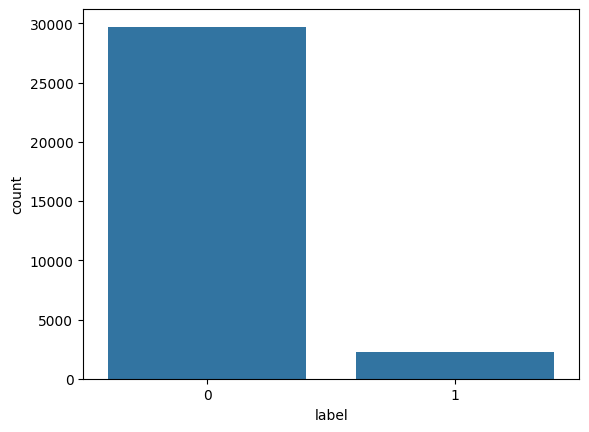

In [71]:
import seaborn as sns
sns.countplot(data=df, x='label')
plt.show()

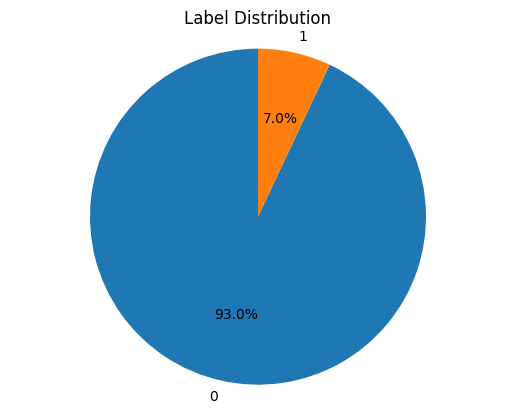

In [72]:
label_counts = df['label'].value_counts()

plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution')
_ = plt.axis('equal')

In [73]:
df_train, df_val = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['label'], random_state=42)

In [74]:
df_train.head()

,id,label,tweet
24845,24846,0,happy bihday to my brother man. needed this mi...
19475,19476,0,lang to sta the week right :) #happiness #s...
18461,18462,0,"note it meditate on it work on it ,but most im..."
3424,3425,0,"@user listening to you this wet mon, ahead of ..."
30489,30490,1,@user @user agreed.. the same is true for and...


In [75]:
sw = set(get_stop_words("en"))
puncts = set(punctuation)
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [76]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:02<00:00, 3741.50it/s]


In [77]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [78]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
max_words = 4000
max_len = 15
num_classes = 1
epochs = 6
batch_size = 512
print_batch_n = 100

In [80]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [81]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [82]:
tokens_filtered_top[:15]

['user',
 'love',
 'day',
 'happy',
 'amp',
 'just',
 'will',
 'u',
 'im',
 'time',
 'life',
 'like',
 'now',
 'today',
 'new']

In [83]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [84]:
import numpy as np


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [85]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]], dtype=np.int32)

In [86]:
x_train.shape

(22373, 15)

In [87]:
x_train[1]

array([151,  66,  74,  75,  28,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [88]:
from torch.utils.data import DataLoader, Dataset
import torch


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [89]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [90]:
from torch import nn


class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)


In [91]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [92]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(4000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 523541


In [93]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    gru_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    gru_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

Epoch [1/6]. Step [44/44]. Loss: 0.346. Acc: 0.845. Test loss: 0.336. Test acc: 0.930
Epoch [2/6]. Step [44/44]. Loss: 0.207. Acc: 0.930. Test loss: 0.232. Test acc: 0.930
Epoch [3/6]. Step [44/44]. Loss: 0.256. Acc: 0.932. Test loss: 0.247. Test acc: 0.935
Epoch [4/6]. Step [44/44]. Loss: 0.162. Acc: 0.937. Test loss: 0.166. Test acc: 0.941
Epoch [5/6]. Step [44/44]. Loss: 0.148. Acc: 0.945. Test loss: 0.164. Test acc: 0.947
Epoch [6/6]. Step [44/44]. Loss: 0.147. Acc: 0.953. Test loss: 0.153. Test acc: 0.949
